# Robust Journey Planning
This is the report notebook of the team "databrewers" whose members are:
* Julien Heitmann [257297]
* Louis Landelle [257309]
* Mathias Gonçalves [258976]

## Importing libraries and creating spark session

In [1]:
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from scipy import sparse
from datetime import timedelta
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from helpers import StochasticCSA

bltin_round = round

In [2]:
import socket

SPARK_LOCAL = False

if not 'iccluster' in socket.gethostname():
    # set this to the base spark directory on your system
    SPARK_LOCAL = True
    spark_home = '/path/to/spark/directory'
    try:
        import findspark
        findspark.init(spark_home)
    except ModuleNotFoundError as e:
        print('Info: {}'.format(e))

import getpass
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, FloatType

In [3]:
from pyspark.sql import SparkSession

if SPARK_LOCAL: # on the laptop
    spark = SparkSession \
        .builder \
        .master("local[2]") \
        .appName("Robust Journey Planning") \
        .config("spark.driver.host", "localhost") \
        .getOrCreate()
    
else: # on the iccluster
    spark = SparkSession \
        .builder \
        .master("yarn") \
        .appName('planning-{0}'.format("databrewers")) \
        .config('spark.executor.memory', '4g') \
        .config('spark.executor.instances', '5') \
        .config('spark.port.maxRetries', '100') \
        .getOrCreate()

In [4]:
sc = spark.sparkContext
spark

## Part I: Load the data

Data is loaded with a wildcard, which makes it possible to load all days of a month at once. A lambda is first defind to ease the loading of the data in the spark dataframes:

In [5]:
path = lambda year, month: "/datasets/sbb/{}/{:02d}/*.csv.bz2".format(year,month)

Loading the data for January 2019.

In [6]:
df = spark.read.format("csv").option("header", "true").option("delimiter", ";").load(path(2019,1))

First look into the dataframe:

In [7]:
df.show(1)

+-----------+-------------------+------------+-------------+--------------------+----------+---------+-----------+---------+-------------------+--------------+-------------+-------+-----------------+------------+-----------+------------------+----------------+-----------+------------------+-------------+
|BETRIEBSTAG|   FAHRT_BEZEICHNER|BETREIBER_ID|BETREIBER_ABK|      BETREIBER_NAME|PRODUKT_ID|LINIEN_ID|LINIEN_TEXT|UMLAUF_ID|VERKEHRSMITTEL_TEXT|ZUSATZFAHRT_TF|FAELLT_AUS_TF|  BPUIC|HALTESTELLEN_NAME|ANKUNFTSZEIT|AN_PROGNOSE|AN_PROGNOSE_STATUS|    ABFAHRTSZEIT|AB_PROGNOSE|AB_PROGNOSE_STATUS|DURCHFAHRT_TF|
+-----------+-------------------+------------+-------------+--------------------+----------+---------+-----------+---------+-------------------+--------------+-------------+-------+-----------------+------------+-----------+------------------+----------------+-----------+------------------+-------------+
| 18.01.2019|80:06____:17004:000|   80:06____|           DB|DB Regio AG Baden...| 

And printing the variable types:

In [10]:
df.schema

StructType(List(StructField(BETRIEBSTAG,StringType,true),StructField(FAHRT_BEZEICHNER,StringType,true),StructField(BETREIBER_ID,StringType,true),StructField(BETREIBER_ABK,StringType,true),StructField(BETREIBER_NAME,StringType,true),StructField(PRODUKT_ID,StringType,true),StructField(LINIEN_ID,StringType,true),StructField(LINIEN_TEXT,StringType,true),StructField(UMLAUF_ID,StringType,true),StructField(VERKEHRSMITTEL_TEXT,StringType,true),StructField(ZUSATZFAHRT_TF,StringType,true),StructField(FAELLT_AUS_TF,StringType,true),StructField(BPUIC,StringType,true),StructField(HALTESTELLEN_NAME,StringType,true),StructField(ANKUNFTSZEIT,StringType,true),StructField(AN_PROGNOSE,StringType,true),StructField(AN_PROGNOSE_STATUS,StringType,true),StructField(ABFAHRTSZEIT,StringType,true),StructField(AB_PROGNOSE,StringType,true),StructField(AB_PROGNOSE_STATUS,StringType,true),StructField(DURCHFAHRT_TF,StringType,true)))

List of columns in the SBB dataset:
- BETRIEBSTAG: date of the trip, type = date
- FAHRT_BEZEICHNER: identifies the trip, type = string
- BETREIBER_ABK, BETREIBER_NAME: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB), type = string
- PRODUKT_ID: type of transport, e.g. train, bus, type = string
- LINIEN_ID: for trains, this is the train number, type = string
- LINIEN_TEXT,VERKEHRSMITTEL_TEXT: for trains, the service type (IC, IR, RE, etc.), type = string
- ZUSATZFAHRT_TF: boolean, true if this is an additional trip (not part of the regular schedule), type = boolean
- FAELLT_AUS_TF: boolean, true if this trip failed (cancelled or not completed), type = boolean
- HALTESTELLEN_NAME: name of the stop, type = string
- ANKUNFTSZEIT: arrival time at the stop according to schedule, type = timestamp
- AN_PROGNOSE: actual arrival time (when AN_PROGNOSE_STATUS is 'REAL'), type = timestamp
- AN_PROGNOSE_STATUS: either 'PROGNOSE', 'REAL' or 'UNBEKANNT', set to 'REAL' if AN_PROGNOSE is the measured time of arrival, type = string
- ABFAHRTSZEIT: departure time at the stop according to schedule, type = timestamp
- AB_PROGNOSE: actual departure time (when AN_PROGNOSE_STATUS is 'REAL'), type = timestamp
- AB_PROGNOSE_STATUS: either 'PROGNOSE', 'REAL' or 'UNBEKANNT', set to 'REAL' if AB_PROGNOSE is the measured time of arrival, type = string
- DURCHFAHRT_TF: boolean, true if the transport does not stop there, type = boolean

In [8]:
print(f"There are {df.count()} different entries in this dataframe.")

There are 37080697 different entries in this dataframe.


In [9]:
n_connections = df.select('FAHRT_BEZEICHNER').distinct().count()

In [10]:
print(f"There are {n_connections} different trips.")

There are 396797 different trips.


We now retrieve all the different station names, so that stations which are not in the Zurich area can be filtered out: 

In [11]:
station_names = [i.HALTESTELLEN_NAME for i in df.select('HALTESTELLEN_NAME').distinct().collect()]

### Loading metadata

As we need to filter out all the stops and station that are further than 10km form the Zurich main stations ("Zürich HB"), we will create a dictionnary that maps a stop/station name to it's distance to the Zurich main station in order to know if we need to filter it out.

In [12]:
# Getting the coordiante of the Zurich main staion ("Zürich HB")
station_meta_path = 'metadata/bfkoordgeo.csv'
station_meta_df = pd.read_csv(station_meta_path).head(-1)
(zurich_long, zurich_lat) = station_meta_df[
    station_meta_df.Remark == 'Zürich HB'
].iloc[:, 1:3].values[0]
print("The coordinates of the zurich main station are : ({}, {})".format(zurich_long,zurich_lat))

The coordinates of the zurich main station are : (8.540192, 47.378177)


Now we define the function to compute the distance between to location using coordinates:

In [13]:
def haversine(lon1, lat1, lon2, lat2):
    """
        Computes the distance between two points using the haversine formula:
        - https://en.wikipedia.org/wiki/Haversine_formula
        
        Code found here:
        - https://kanoki.org/2019/02/14/how-to-find-distance-between-two-points-based-on-latitude-and-longitude-using-python-and-sql/
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
    return c * r

def distance_from_zurich(long, lat):
    return haversine(long, lat, zurich_long, zurich_lat)

Finally creating the dictionnary:


In [14]:
# Creating a mapping from station names to coordinates
station_coord = pd.Series(list(zip(station_meta_df.Longitude,station_meta_df.Latitude)), index=station_meta_df.Remark).to_dict()

# Creating the mapping from stop/station to distance, which is the distance to Zürich HB
station_distance = {station: distance_from_zurich(coord[0],coord[1]) for station, coord in station_coord.items()}

In [15]:
# This is the number of stations that appear in the dataframe but have no metadata entry
unknown_stations = [station for station in station_names if not station in station_distance.keys()]

In [16]:
print("Number of stations in the dataframe:",len(station_names))
print("Number of stations in the metadata:",len(station_distance.keys()))
print("Number of unknown stations:",len(unknown_stations))

Number of stations in the dataframe: 10893
Number of stations in the metadata: 26470
Number of unknown stations: 1692


In [17]:
zurich_area = [station for station, dist in station_distance.items() if dist <= 10.]

In [18]:
print("Number of known stations in the Zurich area:",len(zurich_area))

Number of known stations in the Zurich area: 1040


In [19]:
observed_stations = [station for station in zurich_area if station in station_names]
unobserved_stations = [station for station in zurich_area if not station in station_names]

In [20]:
print("Number of stations in Zurich area that have no logs:",len(unobserved_stations))

Number of stations in Zurich area that have no logs: 92


For stations in the Zurich area, we create a dictionary that maps a station name to an integer value. We create another dictionary that represents the inverse mapping:

In [21]:
station_idx = {}
idx_station = {}
for i,station in enumerate(observed_stations):
    station_idx[station] = i
    idx_station[i] = station

with open("saved_data/station_index.pkl", "wb") as station_to_index, open("saved_data/index_station.pkl", "wb") as index_to_station:
    pickle.dump(station_idx,station_to_index)
    pickle.dump(idx_station,index_to_station)

For a given station, we consider the possibility that one might walk to a close by station. We would like to compute the duration it takes, in minutes, to walk from one station to another, based on the coordinates of the two stations. The [preffered walking speed](https://en.wikipedia.org/wiki/Preferred_walking_speed) is about 1.4 m/s:

In [22]:
WALKING_SPEED = 1.4
def walking_time(distance):
    time_s = (distance*1000) / WALKING_SPEED
    time_m = time_s / 60
    return time_m

We create a (sparse) adjacency matrix, which has the following property: adj(i,j) is the walking time from station i to station j, if j is less than 0.5 km away from i, and an offset. We add a so-called "transition time" of 2 minutes to the walking times, which is defined as the duration it takes to transit from one connection to another at a given stop.

$$
adj(i,j) =
\begin{cases}
    \text{2+walking-time(i,j)},& \text{if j is less that 0.5 km away from i } \\
    0,              & \text{otherwise}
\end{cases}
$$

In [23]:
transition_time = 2 # transition time at stations in minutes 

N = len(observed_stations)
data, rows, cols = [], [], []
for i in range(N):
    for j in range(i+1,N):
        lon1, lat1 = station_coord[idx_station[i]]
        lon2, lat2 = station_coord[idx_station[j]]
        d = haversine(lon1,lat1,lon2,lat2)
        # We consider only stations in a radius of 500m, longer distances are covered by public transport
        if d < 0.5: 
            data.append(walking_time(d)+transition_time) # add transition times
            rows.append(i)
            cols.append(j)
data1 = data + data + [transition_time for _ in range(N)] # add self-loops
rows1 = rows + cols + list(range(N))
cols1 = cols + rows + list(range(N))
adjacency_sparse = sparse.coo_matrix((data1,(rows1,cols1)),shape=(N,N))
adjacency_sparse = adjacency_sparse.tocsr()
sparse.save_npz('saved_data/adjacency_sparse.npz', adjacency_sparse)

## Part II: Data transformation and analysis

In [24]:
adjacency_sparse = sparse.load_npz('saved_data/adjacency_sparse.npz')

### Filter the data

We will use the SBB data limited around the Zurich area. We will focus on all the stops within 10 km of the Zurich train station. We filter the dataframe's entries based on the distance of <`HALTESTELLEN_NAME`> to **Zürich HB**.

In [25]:
# Broadcasted station_distance
meta_b = sc.broadcast(station_distance)

@udf
def dist_to_zurich(station):
    return meta_b.value.get(station, 20.)

In [26]:
# Broadcasted station_idx
station_idx_b = sc.broadcast(station_idx)

@udf
def get_station_idx(station):
    return station_idx_b.value[station]

Now that our data is limited to the Zurich area, we apply some useful transformations, so that it becomes easier to manipulate certain columns (especially datetimes):

In [27]:
zurich_df = df \
.where(dist_to_zurich(df.HALTESTELLEN_NAME) <= 10.) \
.withColumn("DATUM", to_date("BETRIEBSTAG", "dd.MM.yyyy")) \
.withColumn("HALTESTELLEN_ID", get_station_idx(df.HALTESTELLEN_NAME).cast(IntegerType())) \
.withColumn("AN_PLAN", to_timestamp("ANKUNFTSZEIT", "dd.MM.yyyy HH:mm")) \
.withColumn("AN_REAL", to_timestamp("AN_PROGNOSE", "dd.MM.yyyy HH:mm:ss")) \
.withColumn("AB_PLAN", to_timestamp("ABFAHRTSZEIT", "dd.MM.yyyy HH:mm")) \
.withColumn("AB_REAL", to_timestamp("AB_PROGNOSE", "dd.MM.yyyy HH:mm:ss")) \
.drop("BETRIEBSTAG","HALTESTELLEN_NAME","ANKUNFTSZEIT","AN_PROGNOSE","ABFAHRTSZEIT","AB_PROGNOSE")

### First step into the delay statistics

In this part we look at all recorded transportation delays of January 2019, without a distinction between the method of transport, the hour, etc.

In [28]:
measured_arrival = zurich_df.where(col('AN_PROGNOSE_STATUS') == "REAL")

In [29]:
@udf
def time_delta(y,x): 
    delta = (y-x).total_seconds() / 60
    return delta

In [30]:
delays = [i["delta"] for i in measured_arrival.select(time_delta("AN_REAL","AN_PLAN").cast(FloatType()).alias("delta")).collect()]

In [31]:
delays.sort()
print("Min delay:", delays[0])
print("Max delay:", delays[-1])

Min delay: -26.866666793823242
Max delay: 251.9499969482422


In [32]:
filtered_delays = delays[1000:-1000]
print("Min delay:", filtered_delays[0])
print("Max delay:", filtered_delays[-1])

Min delay: -1.5833333730697632
Max delay: 11.916666984558105


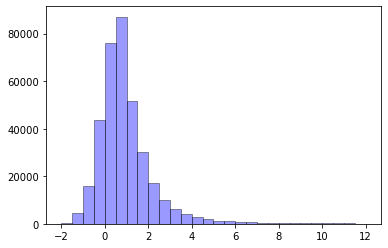

In [33]:
sns.distplot(filtered_delays, hist=True, kde=False, bins=int(14./0.5), color = 'blue', hist_kws={'edgecolor':'black', "range": [-2,12]})

We now clip all the delays in the range [0,10], as delays that are greater than 10 seem to be very unlikely:

In [34]:
from math import ceil

integer_delays = list(map(lambda x: ceil(x) if 0 < x < 10 else 0 if x <= 0 else 10, delays))

In [35]:
n_delays = len(integer_delays)
unique_delays, occur_count = np.unique(integer_delays, return_counts=True)
delay_frequencies = dict(zip(unique_delays,[occur / n_delays for occur in occur_count]))

In [36]:
delay_frequencies

{0: 0.18662117596068092,
 1: 0.4547922217560783,
 2: 0.22282573966387628,
 3: 0.07388720490543915,
 4: 0.028072359117265445,
 5: 0.013055425127873152,
 6: 0.006804157509717248,
 7: 0.00405359975772865,
 8: 0.002486615341444237,
 9: 0.0016725613805021575,
 10: 0.005728939479394433}

From this we can compute a Cumulative Distribution Function (CDF), which is needed for the stochastic implementation of our routing algorithm.

In [37]:
general_cdf = [0 for _ in range(11)]
for i in range(11):
    general_cdf[i] = delay_frequencies.get(i,0) + general_cdf[i-1]
round_4 = lambda x: bltin_round(x,4)
general_cdf = list(map(round_4,general_cdf))

In [38]:
general_cdf

[0.1866,
 0.6414,
 0.8642,
 0.9381,
 0.9662,
 0.9793,
 0.9861,
 0.9901,
 0.9926,
 0.9943,
 1.0]

In [39]:
n_delays = len(delays)
for i in range(4,9):
    thresholded = len([d for d in delays if d >= i])
    ratio = thresholded/float(n_delays)
    print("There are {} delays longer than {} minutes, out of {} delays, corresponding to a ratio of {}"\
          .format(thresholded,i,n_delays,ratio))
    print("Arrival probability with 5 changes:",(1-ratio)**5)

There are 12278 delays longer than 4 minutes, out of 359927 delays, corresponding to a ratio of 0.03411247280698586
Arrival probability with 5 changes: 0.8406840148412145
There are 7536 delays longer than 5 minutes, out of 359927 delays, corresponding to a ratio of 0.02093757900907684
Arrival probability with 5 changes: 0.8996050973507204
There are 5060 delays longer than 6 minutes, out of 359927 delays, corresponding to a ratio of 0.014058406287941722
Arrival probability with 5 changes: 0.9316567663264651
There are 3573 delays longer than 7 minutes, out of 359927 delays, corresponding to a ratio of 0.009927012977631575
Arrival probability with 5 changes: 0.9513406568050062
There are 2678 delays longer than 8 minutes, out of 359927 delays, corresponding to a ratio of 0.007440397636187338
Arrival probability with 5 changes: 0.9633475033212944


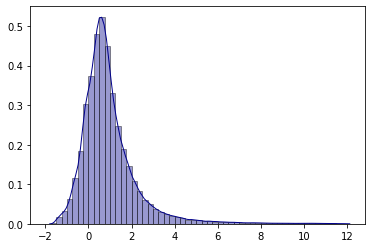

In [40]:
sns.distplot(filtered_delays, hist=True, kde=True, bins=int(14./0.25), color = 'darkblue', hist_kws={'edgecolor':'black', "range": [-2,12]}, kde_kws={'linewidth': 1})

The kernel density estimation of the data is _right-skewed_, we might be able to fit it with a common distribution.

## Part III: Creating the distributions
Making one general distribution is not enough to model the delays, as the delays might depend on many factors such as the hour of the day, the day of the week, the month of the year, etc. In this section we will dig into the distribution of delays with respect to these different factors.

##### We first define the useful functions that are needed

In [43]:
def clip(minim = 0, maxim = 10):
    """
    This function will clip all the delays in the range [0,10], as delays that are greater 
    than 10 seem to be very unlikely.
    """
    
    @udf
    def clip_aux(time_diff):
        if time_diff > maxim:
            return maxim # In order to have bins ranging in [minim; maxim]
        elif time_diff < minim:
            return minim
        else:
            return time_diff
    
    return clip_aux

def diff_from(departure_time):
    """
    Return a function that computes time differences in hour between 
    `departure_time` and `arrival` or `departure`
    """
    
    @udf
    def hour_diff(arrival, departure):
        """
        Computes times differences in hours between 
        `departure_time` and `arrival` or `departure`
        """
        if arrival or departure:
            end = departure if departure else arrival
            return (end - departure_time).total_seconds() / 3600
        else: 
            return 24.
    
    return hour_diff

@udf
def time_delta(y,x): 
    """
    Computes the time difference in minutes between two time stamps
    """
    delta = (y-x).total_seconds() / 60
    return delta

def get_buckets(start = 0, end = 10):
    """
    Creates bucket of uniform width centered in the range [`start`, `end`] (by default [0,10])
    This returns by default [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]
    """
    return (np.arange(start, end+2)-0.5).tolist()

def h_cluster(cluster_dict):
    """
    Return a method that maps an hour of the day to it's corresponding cluster based 
    on the variable `cluster_dict`
    """
    
    @udf
    def get_h_cluster(t,h):
        """
        Maps an hour of the day to it's corresponding cluster based on the variable 
        `cluster_dict`
        """
        return cluster_dict[t][h]
    return get_h_cluster

@udf
def is_weekend(day):
    """
    Say if a `day` of the week is in the week-end or not (1 if yes, 0 else)
    The mapping is:
        1: Sunday
        2: Monday
        3: Tuesday
        4: Wednesday
        5: Thursday
        6: Friday
        7: Saturday
    """
    return 1 if ((day == 1) or (day == 7)) else 0

##### Creating the arrival dataframe
First a dataframe containing all the features we needed to test is created:

In [44]:
arrival_df = zurich_df.select(
    col("PRODUKT_ID").alias('type'),
    col("AN_PLAN").alias('expected_arr'),
    col("AN_REAL").alias('actual_arr'),
    col("VERKEHRSMITTEL_TEXT").alias('subtype')
).dropna().withColumn("time_diff", (clip()(time_delta("actual_arr", "expected_arr"))).cast(FloatType()))\
.withColumn('hour', hour(col("expected_arr")))\
.withColumn('day_of_week', dayofweek(col("expected_arr")))\
.withColumn('day_of_year', dayofyear(col("expected_arr")))

arrival_df.show(3)

+----+-------------------+-------------------+-------+---------+----+-----------+-----------+
|type|       expected_arr|         actual_arr|subtype|time_diff|hour|day_of_week|day_of_year|
+----+-------------------+-------------------+-------+---------+----+-----------+-----------+
| Zug|2019-01-18 21:50:00|2019-01-18 22:16:09|     EC|     10.0|  21|          6|         18|
| Zug|2019-01-18 06:23:00|2019-01-18 06:25:20|     IC|2.3333333|   6|          6|         18|
| Zug|2019-01-18 07:23:00|2019-01-18 07:26:02|     IC|3.0333333|   7|          6|         18|
+----+-------------------+-------------------+-------+---------+----+-----------+-----------+
only showing top 3 rows



Now all the distinct values inside the columns are printed:

##### Getting all the transport types

In [45]:
# Trying to load the data from the disk. 
# If not there, compute it using the distinct() method in the `type` column
try:
    type_list = pickle.load(open('saved_data/type_list.pkl', 'rb'))
except:
    type_list = [row.type for row in arrival_df.select('type').distinct().collect()]
    pickle.dump(type_list, open('saved_data/type_list.pkl', 'wb'))
type_list

['Tram', 'Zug', 'Bus']

So in the perimeter of 10 km around the Zurich Main Station (Zürich HB), one can only take the tram (Tram), the train (Zug) and the bus (Bus).

##### Getting all the days of the week

In [46]:
# Trying to load the data from the disk. 
# If not there, compute it using the distinct() method in the `type` column
try:
    day_of_week_list = pickle.load(open('saved_data/day_of_week_list.pkl', 'rb'))
except:
    day_of_week_list = [row.day_of_week for row in arrival_df.select('day_of_week').distinct().collect()]
    day_of_week_list.sort()
    pickle.dump(day_of_week_list, open('saved_data/day_of_week_list.pkl', 'wb'))
day_of_week_list

[1, 2, 3, 4, 5, 6, 7]

The days of the week are labeled with numbers 1 to 7. The 18th of January 2019 has week day n°6 as shown in the dataframe above. By looking it up in the calender, it appears that this date is a Friday. So the labeling of the weekdays must be as follows:
1. Sunday
2. Monday
3. Tuesday
4. Wednesday
5. Thursday
6. Friday
7. Saturday

##### Getting all the subtypes

In [47]:
# Trying to load the data from the disk. 
# If not there, compute it using the distinct() method in the `type` and `subtype` columns
try:
    subtypes_list = pickle.load(open('saved_data/subtypes_list.pkl', 'rb'))
except:
    subtypes_list = [(row.type,row.subtype) for row in arrival_df.select('type','subtype').distinct().collect()]
    pickle.dump(subtypes_list, open('saved_data/subtypes_list.pkl', 'wb'))
subtypes_list

[('Zug', 'EC'),
 ('Zug', 'TGV'),
 ('Zug', 'RE'),
 ('Tram', 'Trm'),
 ('Zug', 'AG'),
 ('Zug', 'ICE'),
 ('Zug', 'RJ'),
 ('Zug', 'IC'),
 ('Zug', 'SN'),
 ('Zug', 'NJ'),
 ('Zug', 'S'),
 ('Bus', 'Bus'),
 ('Zug', 'EXT'),
 ('Bus', 'BN'),
 ('Zug', 'RJX'),
 ('Zug', 'IR')]

After printing all the subtypes with respect to types, it appears that there is only one category of tram, only 2 categories of busses and 13 categories of trains. It is now necessary to see how many entries all these subtypes have in the `arrival_df` dataframe:

##### Counting the number of data for each subtype

In [ ]:
# Grouping the dataframe by subtype and counting the numnber of entries per type as aggregation values
arrival_df.groupby('subtype').count().show()

So apparently, almost all the busses belong to the category "Bus" so there is no advantage of splitting the data of busses into 2 categories as there won't be enough data to make distribution for the "BN" category. For the trains it is essentially the same problem. Almost all the trains are "S" trains so there won't be enough data to compute all the distributions for all the other categories of trains.

##### Getting all the days of the year (for the month of January)

In [48]:
# Trying to load the data from the disk.
# If not there, compute it using distinct() method in the `day_of_year` column
try:
    day_of_year_list = pickle.load(open('saved_data/day_of_year_list.pkl', 'rb'))
except:
    day_of_year_list = [row.day_of_year for row in arrival_df.select('day_of_year').distinct().collect()]
    day_of_year_list.sort()
    pickle.dump(day_of_year_list, open('saved_data/day_of_year_list.pkl', 'wb'))
day_of_year_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

We will try to see if there are some "outlier" days during the month of January. So, it is necessary to label the day of the year with an ID. Apparently there are 32 days in January, this is because some connections start on the 31st of January and end on the 1st of February.

Now that all the different values are collected, the analysis of distributions can start:

##### Making the histogram for all the public transport types

In [ ]:
buckets = get_buckets()
# Dicts to store the histograms and the the number (`n`) of samples used to make the histograms
transport_hist_dict = {}
transport_n_hist_dict = {}

# Iterate over every type
for t in type_list:
    # Creating rdd of delay for type `t`
    aux = arrival_df.select("time_diff").where(col('type') == t).rdd.flatMap(lambda x: x)
    
    # Computing the histogram with predefined buckets (bins)
    hist = aux.histogram(buckets)[1]
    
    # Getting the number of sample used
    n = np.sum(hist)
    
    # Storing the information
    transport_hist_dict[t]=np.asarray(hist, dtype=np.float32)/n
    transport_n_hist_dict[t] = n

# Saving to disk
pickle.dump(transport_hist_dict, open('saved_data/transport_hist_dict.pkl', 'wb'))
pickle.dump(transport_n_hist_dict, open('saved_data/transport_n_hist_dict.pkl', 'wb'))

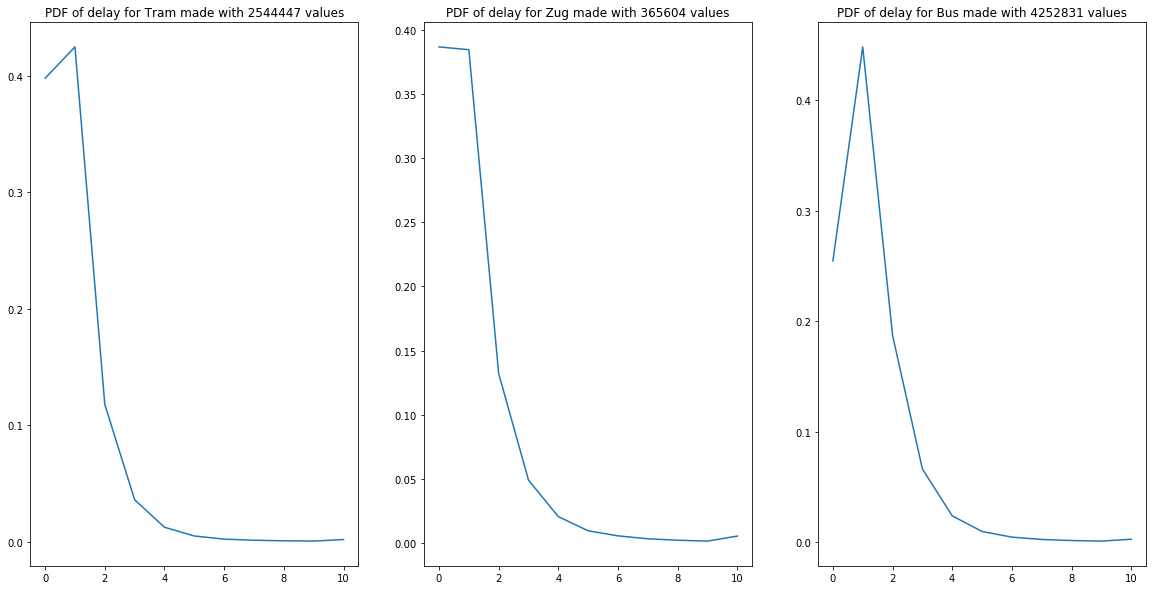

In [49]:
# Reloading from disk (assumed that the previous cell was allready run in the past)
transport_hist_dict = pickle.load(open('saved_data/transport_hist_dict.pkl', 'rb'))
transport_n_hist_dict = pickle.load(open('saved_data/transport_n_hist_dict.pkl', 'rb'))

# Plotting for every transport type
plt.figure(figsize=(20,10))
for i, t in enumerate(transport_hist_dict):
    plt.subplot(1,3,i+1)
    plt.plot(transport_hist_dict[t])
    plt.title("PDF of delay for {} made with {} values".format(t, transport_n_hist_dict[t]))
plt.show()

It appears that the distributions differ from type to type, so it would be a good idea to seperate distributions based on the type.

##### Plotting the distributions for every transport type and month

In [ ]:
# Creating the buckets (bins)
buckets = get_buckets()

# Variable storing the dicts containing the histograms 
# and the the number (`n`) of samples used to make the histograms
month_histograms = []
month_n_histograms = []

# For every month
for m in range(1,13):
    print(m)
    # Loading the data for every month `m` of 2018 (using only 2018 data here)
    df_aux = spark.read.format("csv").option("header", "true").option("delimiter", ";").load(path(2018,m))
    month_df = df_aux.where(dist_to_zurich(df_aux.HALTESTELLEN_NAME) <= 10.).select(
        col("PRODUKT_ID").alias('type'),
        to_timestamp("ANKUNFTSZEIT", "dd.MM.yyyy HH:mm").alias('expected_arr'),
        to_timestamp("AN_PROGNOSE", "dd.MM.yyyy HH:mm").alias('actual_arr')
    ).dropna().withColumn("time_diff", (clip()(time_delta("actual_arr", "expected_arr"))).cast(FloatType()))
    
    hist_dict = {}
    n_dict = {}
    
    # Computing distributions for every transport types
    for t in ['Tram', 'Zug', 'Bus']:
        aux = month_df.select("time_diff").where(col('type') == t).rdd.flatMap(lambda x: x)
        hist = aux.histogram(buckets)[1]
        n = np.sum(hist)
        hist_dict[t]=np.asarray(hist, dtype=np.float32)/n
        n_dict[t] = n
        
    month_histograms.append(hist_dict)
    month_n_histograms.append(n_dict)

# Saving to disk    
pickle.dump(month_histograms, open('saved_data/month_histograms.pkl', 'wb'))
pickle.dump(month_n_histograms, open('saved_data/month_n_histograms.pkl', 'wb'))

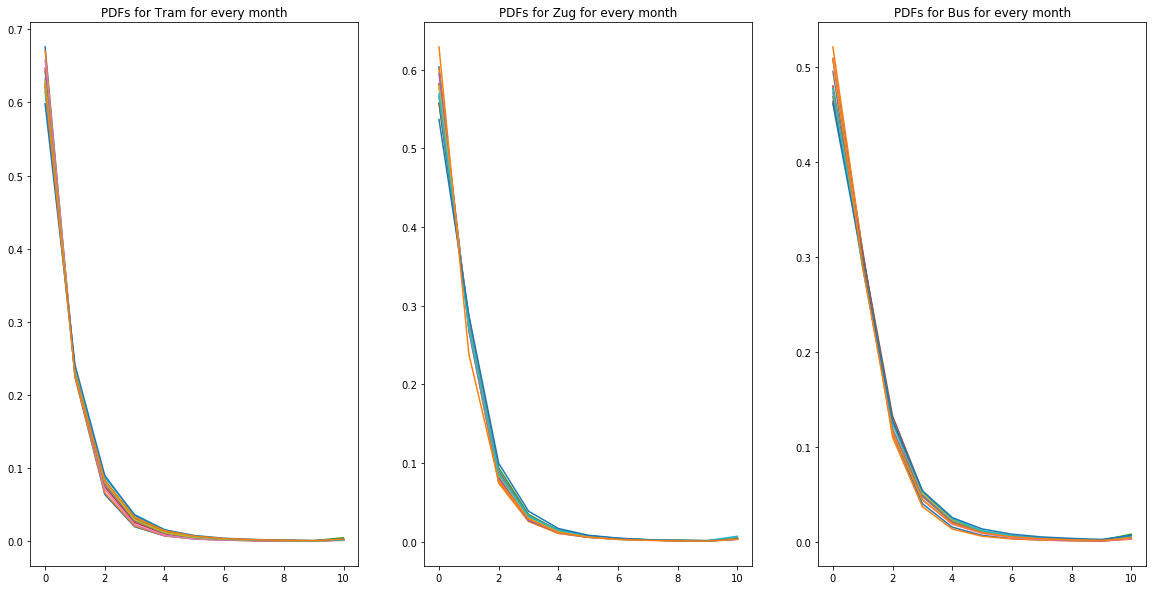

,Tram,Zug,Bus
month,,,
January,2569597,345478,3427388
February,2348321,311254,3290692
Mars,2579922,342808,4163889
April,2447658,331036,3986274
May,2451368,332851,3963842
June,2527431,333822,4083767
July,2534001,345372,4179580
August,2565460,344925,4202242
September,2493390,333416,4100797


In [50]:
month_histograms = pickle.load(open('saved_data/month_histograms.pkl', 'rb'))
month_n_histograms = pickle.load(open('saved_data/month_n_histograms.pkl', 'rb'))

# Plotting the histograms
plt.figure(figsize=(20,10))
for dic in month_histograms:
    for i, t in enumerate(dic):
        plt.subplot(1,3,i+1)
        plt.plot(dic[t])
        plt.title("PDFs for {} for every month".format(t))
plt.show()

# Creating dataframe to show the number of samples used for every month of 2018
ns = []
for hist in month_n_histograms:
    ns.append(list(hist.values()))
month_n_df = pd.DataFrame(ns, columns=type_list)
month_n_df['month'] = [
    'January','February','Mars', 'April', 'May', 'June',
    'July', 'August', 'September', 'October','November', 'December'
]
month_n_df.set_index('month', inplace=True)
month_n_df

The distributions are not identical but almost similar. There are not enough differences in the distributions to make different distributions for every months. Furthermore, all the distributions look different compared to the distribution of January 2019, so either there must be differences between 2018 and 2019 or there are some big "outlier" day(s) in January 2019. This is going to be verified further down.

##### Plotting for every distribution for every hour off the day and transport type

In [ ]:
buckets = get_buckets()
hours_histograms = []
hours_n_histograms = []
for h in range(24):
    hist_dict = {}
    n_dict = {}
    for t in ['Tram', 'Zug', 'Bus']:
        aux = arrival_df.select("time_diff").where((col('type') == t) & (col('hour') == h)).rdd.flatMap(lambda x: x)
        hist = aux.histogram(buckets)[1]
        n = np.sum(hist)
        n_dict[t] = n
        if n != 0:
            hist_dict[t]=np.asarray(hist, dtype=np.float32)/n
        else:
            # If no data assuming Pr(delay = 0) = 1
            hist_dict[t]=np.asarray([1,0,0,0,0,0,0,0,0,0,0], dtype=np.float32)
    
    hours_histograms.append(hist_dict)
    hours_n_histograms.append(n_dict)
    
pickle.dump(hours_histograms, open('saved_data/hours_histograms.pkl', 'wb'))
pickle.dump(hours_n_histograms, open('saved_data/hours_n_histograms.pkl', 'wb'))

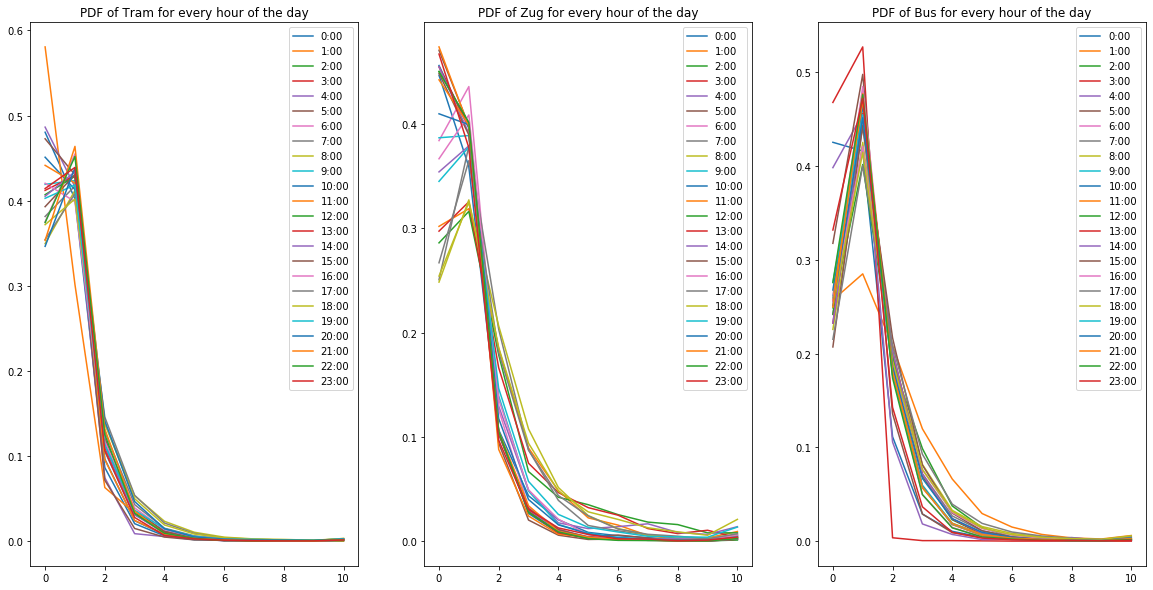

,Tram,Zug,Bus
0,64579,8686,91369
1,1493,1299,10267
2,0,1259,8748
3,0,1245,3949
4,2066,1082,3662
5,68012,8058,86197
6,127045,19788,221887
7,133375,21175,261037
8,137201,20491,250940
9,135144,18973,222795


In [51]:
hours_histograms = pickle.load(open('saved_data/hours_histograms.pkl', 'rb'))
hours_n_histograms = pickle.load(open('saved_data/hours_n_histograms.pkl', 'rb'))

plt.figure(figsize=(20,10))
for h, dic in enumerate(hours_histograms):
    for i, t in enumerate(dic):
        plt.subplot(1,3,i+1)
        plt.plot(dic[t], label=str(h)+":00")
        plt.title('PDF of {} for every hour of the day'.format(t))
        plt.legend()
plt.show()

ns = []
for hist in hours_n_histograms:
    ns.append(list(hist.values()))
hours_n_df = pd.DataFrame(ns, columns=type_list)
hours_n_df

It seems like there can be big differences between the distributions depending on hours of the day for every transport type. So it might be a good idea to make different distributions for different hours of the day. However as the number of samples is divided by 24 for every hour of the day, some hour's distribution might not be very accurate, so the hours will be later clustered into groups depending on the similarity of their distribution in order to have enough samples for every cluster of hours.

##### Plotting every distribution for every day of the week

In [ ]:
buckets = get_buckets()
day_of_week_histograms = []
day_of_week_n_histograms = []
for d in day_of_week_list:
    hist_dict = {}
    n_dict = {}
    for t in ['Tram', 'Zug', 'Bus']:
        aux = arrival_df.select("time_diff").where((col('type') == t) & (col('day_of_week') == d)).rdd.flatMap(lambda x: x)
        hist = aux.histogram(buckets)[1]
        n = np.sum(hist)
        n_dict[t] = n
        if n != 0:
            hist_dict[t]=np.asarray(hist, dtype=np.float32)
    
    day_of_week_histograms.append(hist_dict)
    day_of_week_n_histograms.append(n_dict)
    
pickle.dump(day_of_week_histograms, open('saved_data/day_of_week_histograms.pkl', 'wb'))
pickle.dump(day_of_week_n_histograms, open('saved_data/day_of_week_n_histograms.pkl', 'wb'))

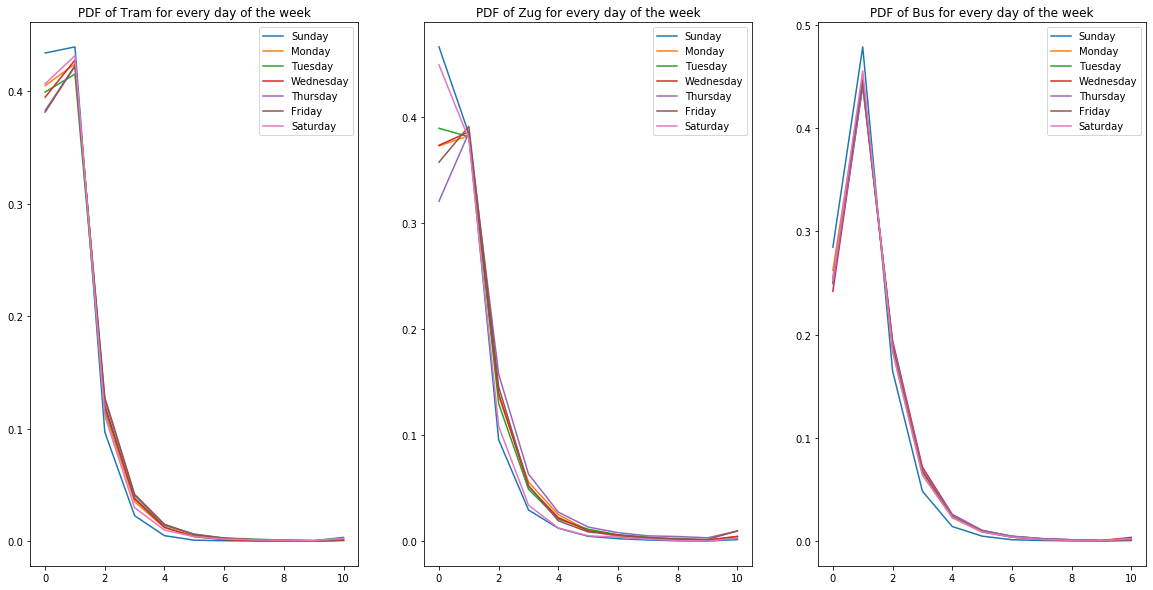

,Tram,Zug,Bus
day,,,
Sunday,247065,45986,389064
Monday,350683,47643,602490
Tuesday,412569,59407,695335
Wednesday,411563,58793,700680
Thursday,438352,59530,754347
Friday,357012,48052,609508
Saturday,327203,46193,501407


In [52]:
day_of_week_histograms = pickle.load(open('saved_data/day_of_week_histograms.pkl', 'rb'))
day_of_week_n_histograms = pickle.load(open('saved_data/day_of_week_n_histograms.pkl', 'rb'))

num2day = {
    1:'Sunday',
    2:'Monday',
    3:'Tuesday',
    4:'Wednesday',
    5:'Thursday',
    6:'Friday',
    7:'Saturday'
}

plt.figure(figsize=(20,10))
for day, dic in enumerate(day_of_week_histograms):
    for i, t in enumerate(dic):
        plt.subplot(1,3,i+1)
        plt.plot(dic[t],label=num2day[day+1])
        plt.title('PDF of {} for every day of the week'.format(t))
        plt.legend()
plt.show()

ns = []
for hist in day_of_week_n_histograms:
    ns.append(list(hist.values()))
week_n_df = pd.DataFrame(ns, columns=type_list)
week_n_df['day'] = num2day.values()
week_n_df.set_index('day', inplace=True)
week_n_df

It seems that (mainly for the train distribution) the delays during the weekend are smaller. So it might be a good idea to cluster depending on whether the day is a weekday or a week-end day.

##### Plotting every distribution for every day of the month of january

In [ ]:
buckets = get_buckets()
day_of_year_histograms = []
day_of_year_n_histograms = []
for d in day_of_year_list:
    hist_dict = {}
    n_dict = {}
    for t in ['Tram', 'Zug', 'Bus']:
        aux = arrival_df.select("time_diff").where((col('type') == t) & (col('day_of_year') == d)).rdd.flatMap(lambda x: x)
        hist = aux.histogram(buckets)[1]
        n = np.sum(hist)
        n_dict[t] = n
        if n != 0:
            hist_dict[t]=np.asarray(hist, dtype=np.float32)/n
        else:
            hist_dict[t]=np.asarray([1,0,0,0,0,0,0,0,0,0,0], dtype=np.float32)
    
    day_of_year_histograms.append(hist_dict)
    day_of_year_n_histograms.append(n_dict)
    
pickle.dump(day_of_year_histograms, open('saved_data/day_of_year_histograms.pkl', 'wb'))
pickle.dump(day_of_year_n_histograms, open('saved_data/day_of_year_n_histograms.pkl', 'wb'))

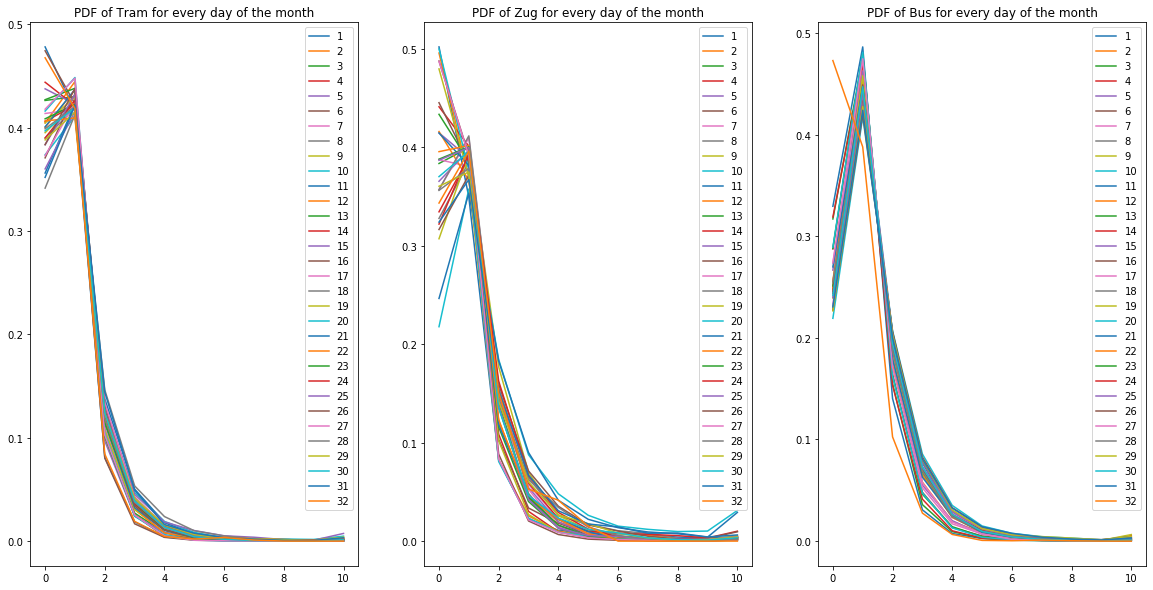

,Tram,Zug,Bus
0,59135,11689,90438
1,62539,11077,96782
2,86865,11987,151073
3,87858,11988,151808
4,81252,11548,124681
5,62000,11555,97332
6,88615,11994,150368
7,87859,11985,151058
8,86848,11985,150994
9,89315,11975,151296


In [53]:
day_of_year_histograms = pickle.load(open('saved_data/day_of_year_histograms.pkl', 'rb'))
day_of_year_n_histograms = pickle.load(open('saved_data/day_of_year_n_histograms.pkl', 'rb'))

plt.figure(figsize=(20,10))
for d, dic in enumerate(day_of_year_histograms):
    for i, t in enumerate(dic):
        plt.subplot(1,3,i+1)
        plt.plot(dic[t], label=str(day_of_year_list[d]))
        plt.title('PDF of {} for every day of the month'.format(t))
        plt.legend()
plt.show()

ns = []
for hist in day_of_year_n_histograms:
    ns.append(list(hist.values()))
hours_n_df = pd.DataFrame(ns, columns=type_list)
hours_n_df

By looking at the plots, we cannot say that there are some "outlier" days. So this hypothesis is rejected. It is then assumed that there are some differences between 2018 and 2019. Only the distribution of January 2019 will be used since this is the only available month for 2019.

##### Clustering the hours of the day
This next cell will create a numpy array of shape (24,3,11):
* 24: the number of hours
* 3: the number of types
* 11: the number of bins in the histogram (distribution)

In [54]:
# Creating a numpy histogram array for feeding the k-means algorithm
histogram_array = []

# For every transport type
for dic in hours_histograms:
    sub_histogram_array = []
    
    # For every hour of the day
    for hist in dic.values():
        sub_histogram_array.append(np.asarray(hist))
    histogram_array.append(np.array(sub_histogram_array))
histogram_array = np.array(histogram_array)
histogram_array[histogram_array == np.inf] = 1
histogram_array = np.nan_to_num(histogram_array)

Running the k-means algorithm for every type and storing the cluster center and the cluster assignment for every hour:

In [55]:
hour_cluster_dict = {}
cluster_centers_dict = {}

for i, t in enumerate(type_list):
    hours_k_mean = KMeans(n_clusters=6, n_jobs=-1)
    hours_cluster = hours_k_mean.fit_predict(histogram_array[:,i,:])
    hour_cluster_dict[type_list[i]] = hours_cluster.tolist()
    cluster_centers_dict[type_list[i]] = hours_k_mean.cluster_centers_
    
pickle.dump(hour_cluster_dict, open('saved_data/hour_cluster_dict.pkl', 'wb'))
hour_cluster_dict

{'Tram': [0,
  3,
  1,
  1,
  0,
  0,
  5,
  2,
  2,
  4,
  0,
  0,
  4,
  4,
  4,
  4,
  4,
  2,
  2,
  4,
  5,
  5,
  5,
  4],
 'Zug': [0,
  3,
  3,
  3,
  2,
  0,
  4,
  5,
  1,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  4,
  5,
  1,
  2,
  4,
  0,
  0,
  0],
 'Bus': [3,
  4,
  0,
  2,
  3,
  5,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  5]}

Plotting the 6 cluster centers for every type:

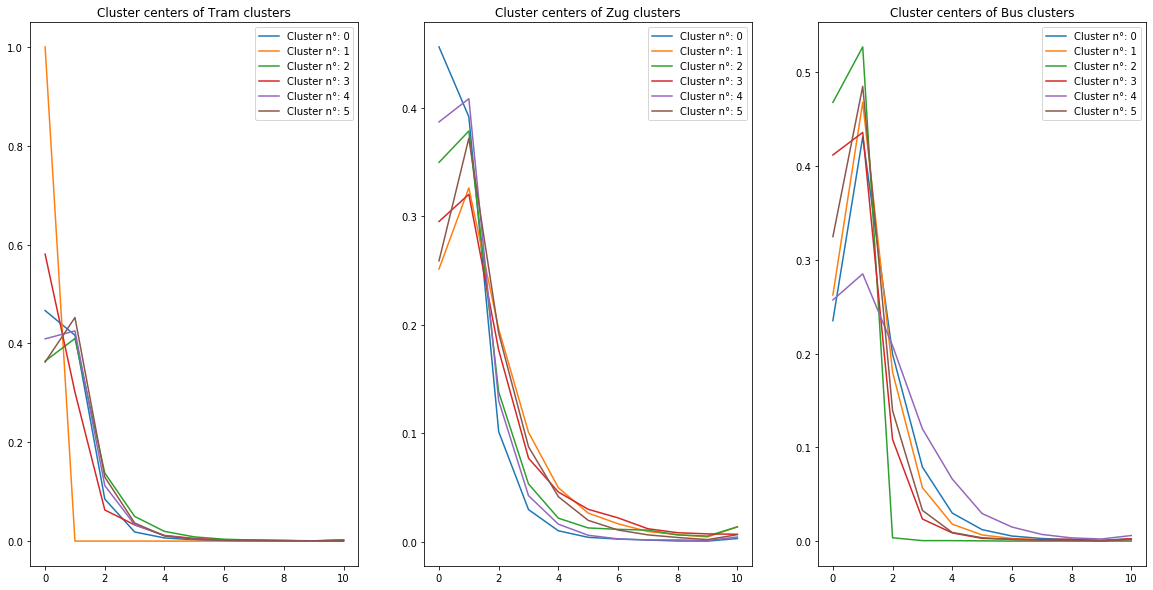

In [56]:
plt.figure(figsize=(20,10))
for i, t in enumerate(cluster_centers_dict):
    for j, cluster_center in enumerate(cluster_centers_dict[t]):
        plt.subplot(1,3,i+1)
        plt.plot(cluster_center, label='Cluster n°: '+str(j))
        plt.title('Cluster centers of {} clusters'.format(t))
        plt.legend()
plt.show()

Adding the cluster assignment for every entry in the dataframe based on the transport type and the hour of the day:

In [57]:
hour_cluster_dict = pickle.load(open('saved_data/hour_cluster_dict.pkl', 'rb'))

arrival_df = arrival_df.withColumn(
    'is_weekend',
    is_weekend('day_of_week')
).withColumn(
    'hour_cluster',
    h_cluster(hour_cluster_dict)('type','hour')
)
arrival_df.show()

+----+-------------------+-------------------+-------+----------+----+-----------+-----------+----------+------------+
|type|       expected_arr|         actual_arr|subtype| time_diff|hour|day_of_week|day_of_year|is_weekend|hour_cluster|
+----+-------------------+-------------------+-------+----------+----+-----------+-----------+----------+------------+
| Zug|2019-01-18 21:50:00|2019-01-18 22:16:09|     EC|      10.0|  21|          6|         18|         0|           0|
| Zug|2019-01-18 06:23:00|2019-01-18 06:25:20|     IC| 2.3333333|   6|          6|         18|         0|           4|
| Zug|2019-01-18 07:23:00|2019-01-18 07:26:02|     IC| 3.0333333|   7|          6|         18|         0|           5|
| Zug|2019-01-18 08:23:00|2019-01-18 08:24:01|     IC| 1.0166667|   8|          6|         18|         0|           1|
| Zug|2019-01-18 08:26:00|2019-01-18 08:29:41|     IC| 3.6833334|   8|          6|         18|         0|           1|
| Zug|2019-01-18 17:53:00|2019-01-18 17:54:13|  

##### Creating final distributions
This final distributions are created here for every transport type, every hour (based on the cluster assignment) and every day of the week (clustered by weekend/weekdays).

In [ ]:
buckets = get_buckets()
final_histograms = {}

already_computed_tuples = {}

# For every transport type
for t in type_list:
    day_histograms = {}
    
    # For every day of the week
    for d in day_of_week_list:
        hour_histograms = {}
        
        # For every hour of the day
        for h in range(24):
            print(t, d, h)
            # Getting the day is in the weekend or
            is_we = 1 if d in [1,7] else 0
            
            # Getting the cluster of the specific hour of the day
            h_clust = hour_cluster_dict[t][h]
            
            # Checking if the histogram has already been computed
            retrieved_hist = already_computed_tuples.get((t,is_we,h_clust))
            print(retrieved_hist)
            if retrieved_hist is None:
                # If the histogram has not been computed
                
                # Computing the histogram for the type, is_weekend and the hour cluster
                aux = arrival_df.select("time_diff").where(
                    (col('type') == t) & \
                    (col('is_weekend') == is_we) & \
                    (col('hour_cluster') == h_clust)
                ).rdd.flatMap(lambda x: x)
                hist = aux.histogram(buckets)[1]
                n = np.sum(hist)
                if n != 0:
                    hour_histograms[h]=np.asarray(hist, dtype=np.float32)/n
                else:
                    hour_histograms[h]=np.asarray([1,0,0,0,0,0,0,0,0,0,0], dtype=np.float32)
            
                # Adding the histogram to the computed histograms
                already_computed_tuples[(t,is_we,h_clust)] = hour_histograms[h]
            
            else:
                # Setting from previously computed histograms
                hour_histograms[h] = retrieved_hist
        
        # Updating the day dictionnary
        day_histograms[d] = hour_histograms
    
    # Updating the transport type dictionnary
    final_histograms[t] = day_histograms

# Saving to disk
pickle.dump(final_histograms, open('saved_data/final_histograms.pkl', 'wb'))

In [58]:
final_histograms = pickle.load(open('saved_data/final_histograms.pkl', 'rb'))

The stochastic algorithm described further down will need Cumulative Distribution Functions (CDF) instead of Probability Density Functions (PDF). So the CDFs are created from the histograms (PDF) computed above:

In [59]:
final_cdfs = {}
for t in type_list:
    day_cdfs = {}
    for d in day_of_week_list:
        hour_cdfs = {}
        for h in range(24):
            hour_cdfs[h] = np.cumsum(final_histograms[t][d][h]).tolist()
        day_cdfs[d] = hour_cdfs
    final_cdfs[t] = day_cdfs

pickle.dump(final_cdfs, open('saved_data/final_cdfs.pkl', 'wb'))

In [60]:
final_cdfs = pickle.load(open('saved_data/final_cdfs.pkl', 'rb'))

In [61]:
final_cdfs

{'Tram': {1: {0: [0.46812790047388714,
    0.8826565152124644,
    0.9695162034084555,
    0.9908165968427146,
    0.9955554683437497,
    0.9968701863171218,
    0.9976943378825192,
    0.9982830175720887,
    0.9986656593703089,
    0.9989599992150937,
    1.0],
   1: [0.4166666567325592,
    0.8009259104728699,
    0.875,
    0.9328703880310059,
    0.9652777910232544,
    0.9814814925193787,
    0.9884259104728699,
    0.9953703284263611,
    0.9999999403953552,
    0.9999999403953552,
    0.9999999403953552],
   2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   3: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   4: [0.46812790047388714,
    0.8826565152124644,
    0.9695162034084555,
    0.9908165968427146,
    0.9955554683437497,
    0.9968701863171218,
    0.9976943378825192,
    0.9982830175720887,
    0.9986656593703089,
    0.9989599992150937,
    1.0],
   5: [0.46812790047388714,
    0.8826565152124644,
    0.9695162034084555,
    0.9908165968427146,


## Part IV: Connection Scan Algorithm

### Getting all trips

We now take a look at all trips in the Zurich area, removing non-essential information:

In [41]:
zurich_trips = zurich_df.select(
    col("DATUM").alias("date"),
    col("FAHRT_BEZEICHNER").alias("trip_id"),
    col("PRODUKT_ID").alias("type"),
    col("HALTESTELLEN_ID").alias("station"),
    col("AN_PLAN").alias("arrival"),
    col("AB_PLAN").alias("departure"),
    dayofweek(col("AN_PLAN")).alias("day_of_week"),
    hour(col("AN_PLAN")).alias("hour"))

In [42]:
zurich_trips.show()

+----------+--------------+----+-------+-------------------+-------------------+-----------+----+
|      date|       trip_id|type|station|            arrival|          departure|day_of_week|hour|
+----------+--------------+----+-------+-------------------+-------------------+-----------+----+
|2019-01-18|  85:11:10:001| Zug|      9|2019-01-18 21:50:00|               null|          6|  21|
|2019-01-18|85:11:1007:001| Zug|      9|2019-01-18 06:23:00|               null|          6|   6|
|2019-01-18|85:11:1009:001| Zug|      9|2019-01-18 07:23:00|               null|          6|   7|
|2019-01-18|85:11:1011:001| Zug|      9|2019-01-18 08:23:00|               null|          6|   8|
|2019-01-18|  85:11:11:001| Zug|      9|               null|2019-01-18 06:10:00|       null|null|
|2019-01-18|  85:11:12:001| Zug|      9|2019-01-18 10:50:00|               null|          6|  10|
|2019-01-18|85:11:1251:001|null|      9|2019-01-18 07:00:00|               null|          6|   7|
|2019-01-18|85:11:12

We first define an example trip to test our implementation of the Connection Scan Algorithm (CSA):

In [62]:
departure_station = "Kloten Balsberg"
arrival_station = "Schwerzenbach ZH" 
departure_time = datetime.datetime.strptime("02.01.2019 12:00", "%d.%m.%Y %H:%M") # Wednesday
trip_window = 4. # length in hours of trip window to consider, starting from departure_time

Only trips that depart no earlier than `departure_time`, and no later than `(departure_time + trip_window)` are given as input to the CSA. The next transformation removes trips that do not fall into this range.

In [63]:
trips_in_range = zurich_trips.select(
    "trip_id",
    "type",
    "station",
    "arrival",
    "departure",
    "day_of_week",
    "hour",
    diff_from(departure_time)("arrival","departure").alias("diff")) \
.where((0. <= col("diff")) & (col("diff") < trip_window)) \
.drop("diff") \
.cache()

In [64]:
trips_in_range.show()

+--------------+----+-------+-------------------+-------------------+-----------+----+
|       trip_id|type|station|            arrival|          departure|day_of_week|hour|
+--------------+----+-------+-------------------+-------------------+-----------+----+
|85:11:1376:003| Zug|      9|2019-01-02 15:14:00|               null|          4|  15|
|  85:11:14:001| Zug|      9|2019-01-02 12:50:00|               null|          4|  12|
|85:11:1519:001| Zug|      9|2019-01-02 12:30:00|2019-01-02 12:39:00|          4|  12|
|85:11:1519:001| Zug|     13|2019-01-02 12:45:00|2019-01-02 12:46:00|          4|  12|
|85:11:1519:001| Zug|     20|2019-01-02 12:51:00|2019-01-02 12:53:00|          4|  12|
|85:11:1520:001| Zug|     20|2019-01-02 12:07:00|2019-01-02 12:09:00|          4|  12|
|85:11:1520:001| Zug|     13|2019-01-02 12:13:00|2019-01-02 12:15:00|          4|  12|
|85:11:1520:001| Zug|      9|2019-01-02 12:21:00|2019-01-02 12:30:00|          4|  12|
|85:11:1521:001| Zug|      9|2019-01-02 13:

Now that we have a set of trips, we need to establish connections, that is entries in a dataframe with an `departure_station` and an `arrival_station`. The `arrival_station` is determined with the help of a window function. 

In [65]:
connection_window = Window.partitionBy("trip_id").orderBy("arrival")

next_station = lead(col("station")) \
.over(connection_window) \
.alias("arrival_station")

next_arrival = lead(col("arrival")) \
.over(connection_window) \
.alias("arrival_timestamp")

next_day_of_week = lead(col("day_of_week")) \
.over(connection_window) \
.alias("c_day")

next_hour = lead(col("hour")) \
.over(connection_window) \
.alias("c_hour")

In [66]:
connections = trips_in_range.select(
    col("trip_id"),
    col("type"),
    col("station").alias("departure_station"), 
    next_station,
    col("departure").alias("departure_timestamp"),
    next_arrival,
    next_day_of_week,
    next_hour) \
.dropna(subset=["departure_timestamp","arrival_timestamp"]) \
.sort("departure_timestamp") \
.cache()

We now have a complete timetable of connections, sorted by `departure_timestamp`:

In [67]:
timetable = [row.asDict() for row in connections.collect()]

Now we can add the computed CDFs, based on a connection's features, and assign a general CDF if some features are not available:

In [68]:
stochastic_timetable = []
for row in timetable:
    c_type = row["type"]
    c_day = row["c_day"]
    c_hour = row["c_hour"]
    stochastic_row = row.copy()
    stochastic_row["cdf"] = final_cdfs[c_type][c_day][c_hour] if (c_type and c_day and c_hour) else general_cdf
    stochastic_timetable.append(stochastic_row)
    
with open("saved_data/stochastic_timetable.pkl", "wb") as serialized_table:
    pickle.dump(stochastic_timetable,serialized_table)

This will yield a stochastic timetable, which will be used in the probabilistic CSA.

In [69]:
print(timetable[0])
print(stochastic_timetable[0])

{'trip_id': '85:3849:34872-05017-1', 'type': 'Tram', 'departure_station': 773, 'arrival_station': 728, 'departure_timestamp': datetime.datetime(2019, 1, 2, 12, 0), 'arrival_timestamp': datetime.datetime(2019, 1, 2, 12, 0), 'c_day': 4, 'c_hour': 12}
{'trip_id': '85:3849:34872-05017-1', 'type': 'Tram', 'departure_station': 773, 'arrival_station': 728, 'departure_timestamp': datetime.datetime(2019, 1, 2, 12, 0), 'arrival_timestamp': datetime.datetime(2019, 1, 2, 12, 0), 'c_day': 4, 'c_hour': 12, 'cdf': [0.4061215611435054, 0.827445475827657, 0.9427382022525923, 0.9785676859253848, 0.9907896571118173, 0.9952325900003366, 0.997086916602172, 0.9979041182154241, 0.9983692020747309, 0.998623976695333, 1.0000000000000002]}


In [72]:
def print_route(departure_station, arrival_station, route):
    """
    Simple route printing method used for testing purposes
    """
    for i in range(len(route)):
        c = route[i]
        next_departure = idx_station[c["departure_station"]]
        next_arrival = idx_station[c["arrival_station"]]
        
        print("Take the {} {} from {} to {} || {} ==> {}".format(
            c["type"],
            c["trip_id"],
            next_departure,
            next_arrival,
            c["departure_timestamp"],
            c["arrival_timestamp"]
        ))

We run the CSA and print the computed route:

In [73]:
csa = StochasticCSA(stochastic_timetable,adjacency_sparse)
departure_idx = station_idx[departure_station]
arrival_idx = station_idx[arrival_station]
csa.compute(departure_idx,departure_time,0.5,trip_window,arrival_station=arrival_idx)
route = csa.get_route(departure_idx,arrival_idx,departure_time)
print_route(departure_station,arrival_station,route)

Route probability: 1
Take the Zug 85:11:18747:001 from Kloten Balsberg to Opfikon || 2019-01-02 12:26:00 ==> 2019-01-02 12:29:00
Take the Zug 85:11:18747:001 from Opfikon to Zürich Oerlikon || 2019-01-02 12:29:00 ==> 2019-01-02 12:32:00
Take the Zug 85:11:19447:001 from Zürich Oerlikon to Wallisellen || 2019-01-02 12:48:00 ==> 2019-01-02 12:51:00
Take the Zug 85:11:19447:001 from Dübendorf to Schwerzenbach ZH || 2019-01-02 12:55:00 ==> 2019-01-02 12:58:00


Several experiments to check the validity of the algorithm:

In [82]:
csa = StochasticCSA(stochastic_timetable,adjacency_sparse)

n_experiments = 10
n_stations = adjacency_sparse.shape[0]
for i in range(n_experiments):
    random_indices = np.random.choice(n_stations, 2, replace=False)
    departure_idx = random_indices[0]
    arrival_idx = random_indices[1]
    csa.compute(departure_idx,departure_time,0.5,trip_window,arrival_station=arrival_idx)
    route = csa.get_route(departure_idx,arrival_idx,departure_time)
    print("Number of connections:",len(route))
    print_route(idx_station[departure_idx],idx_station[arrival_idx],route)

Route probability: 0.997151365620067
Number of connections: 4
Take the Bus 85:801:42883-25501-1 from Rümlang, Riedmatt to Rümlang, Bahnhof || 2019-01-02 12:53:00 ==> 2019-01-02 12:57:00
Take the Bus 85:801:42883-25501-1 from Kloten Balsberg, Bahnhof to Zürich Flughafen, Bahnhof || 2019-01-02 13:06:00 ==> 2019-01-02 13:09:00
Take the Bus 85:801:43151-06504-1 from Zürich Flughafen, Bahnhof to Zürich Flughafen, OPC || 2019-01-02 13:20:00 ==> 2019-01-02 13:20:00
Take the Bus 85:801:43151-06504-1 from Kloten, Zum Wilden Mann to Kloten, Freienberg || 2019-01-02 13:24:00 ==> 2019-01-02 13:26:00
Route probability: 0.9390041175058809
Number of connections: 9
Take the Tram 85:3849:33574-05010-1 from Zürich Flughafen, Fracht to Zürich Flughafen, Bahnhof || 2019-01-02 12:15:00 ==> 2019-01-02 12:16:00
Take the Walk  from Zürich Flughafen, Bahnhof to Zürich Flughafen || 2019-01-02 12:16:00 ==> 2019-01-02 12:19:12.171444
Take the Zug 85:11:19647:001 from Zürich Flughafen to Zürich Oerlikon || 2019-01

Route probability: 0.881013704941547
Number of connections: 7
Take the Bus 85:773:3039-10759-1 from Rümlang, Oberdorf to Rümlang, Gemeindehaus || 2019-01-02 12:11:00 ==> 2019-01-02 12:12:00
Take the Walk  from Rümlang, Gemeindehaus to Rümlang || 2019-01-02 12:12:00 ==> 2019-01-02 12:19:54.465088
Take the Zug 85:11:19547:002 from Rümlang to Glattbrugg || 2019-01-02 12:23:00 ==> 2019-01-02 12:26:00
Take the Walk  from Glattbrugg to Glattbrugg, Bahnhof || 2019-01-02 12:26:00 ==> 2019-01-02 12:28:34.818805
Take the Tram 85:3849:33495-05010-1 from Glattbrugg, Bahnhof to Rümlang, Bäuler || 2019-01-02 12:35:00 ==> 2019-01-02 12:37:00
Take the Tram 85:3849:33495-05010-1 from Zürich Flughafen, Bahnhof to Zürich Flughafen, Fracht || 2019-01-02 12:41:00 ==> 2019-01-02 12:43:00
Take the Walk  from Zürich Flughafen, Fracht to Kloten, Obstgartenstrasse || 2019-01-02 12:43:00 ==> 2019-01-02 12:50:07.304733


## Stop the Spark Context

In [83]:
sc.stop()

## Part V: web-demo

We have developped a web demo for our algorithms in the form of a webserver written in Flask, using Folium for map visualizations, that can run from this notebook and host a website locally. This is where you will be able to test route planning in all of Zürich, and visualize isochrone maps from any origin station in the city.

We have tried to mimic what the end user of a company that would use our algorithm might see. As we have completely modularized our project, and interfaced the backend in interface.py, all of this code is dettached from the previous cells. 

First, we will import the necessary code.

In [1]:

import sys
sys.path.append("./flaskcode/")

import flaskcode.journey_planner_main as jp


The following code cell will start the webserver which will run indefinitely until you stop the Kernel. To visit our webserver, you can either do it from the ssh by connecting via http here: [10.90.38.18:2019](http://10.90.38.18:2019), or if you pull the repository locally, directly in localhost/127.0.0.1 here : [localhost:2019](http://localhost:2019)

If port 2019 happens to be occupied, you are able to replace it with any free port in the argument of the following line.

In [4]:
jp.start(port=2019, use_reloader=False, debug=False)

 * Running on http://0.0.0.0:2019/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Jun/2019 10:29:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2019 10:29:29] "GET /static/dbjp_style.css HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2019 10:29:29] "GET /static/autocomplete.css HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2019 10:29:29] "GET /static/autocomplete.js HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2019 10:29:29] "GET /static/logo.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2019 10:29:29] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [19/Jun/2019 10:39:56] "POST / HTTP/1.1" 302 -
127.0.0.1 - - [19/Jun/2019 10:39:57] "GET /result?stn_from=D%C3%BCbendorf&stn_to=Z%C3%BCrich+Flughafen&qvalue=90&date=2019-01-02&time=12%3A00 HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2019 10:39:57] "GET /static/pt.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2019 10:39:57] "GET /static/Zug.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Jun/2019 10:39:57] "GET /map?fname=steps.html HTTP/1.1" 200 -


Route probability: 0.9345230678144782


127.0.0.1 - - [19/Jun/2019 10:39:57] "GET /static/dbjp_style.css HTTP/1.1" 200 -


## Part VI: References

For the Connection Scan Algorithm, Julian Dibbelt, Thomas Pajor, Ben Strasser, Dorothea Wagner


[arxiv link to the paper](https://arxiv.org/abs/1703.05997)